In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib_venn import venn2, venn2_circles # did pip install matplotlib-venn
import matplotlib.pyplot as plt

from utils import evaluate_model

# Part 1: Read in training datasets

In [2]:
# get training dataset for sa
sa = pd.read_csv('../data/training_data/SA/combined_SA_screen_39K.csv')
sa = sa[['SA_Activity', 'Compound_ID']]

# get training dataset for NG
ng = pd.read_csv('../data/training_data/NG/FULL_03_19_2022.csv')
ng = ng[['hit', 'Name']]
ng.columns = ['NG_Activity', 'Compound_ID']
ng = ng.drop_duplicates('Compound_ID')

# merge
merge = sa.merge(ng, on = 'Compound_ID', how = 'inner')
merge['SA_Activity'] = ['SA-Active' if x == 1.0 else 'SA-Inactive' for x in list(merge['SA_Activity'])]
merge['NG_Activity'] = ['NG-Active' if x == 1.0 else 'NG-Inactive' for x in list(merge['NG_Activity'])]
merge

,SA_Activity,Compound_ID,NG_Activity
0,SA-Inactive,BRD-K49267252,NG-Inactive
1,SA-Inactive,BRD-K85924431,NG-Inactive
2,SA-Inactive,BRD-A97790207,NG-Inactive
3,SA-Inactive,BRD-K72088705,NG-Inactive
4,SA-Inactive,BRD-K81185262,NG-Inactive
...,...,...,...
38607,SA-Inactive,alpha-TOCHOPHERYL ACETATE [4mM],NG-Inactive
38608,SA-Inactive,beta-CAROTENE [2mM],NG-Inactive
38609,SA-Inactive,d-LIMONENE,NG-Inactive
38610,SA-Inactive,gamma-AMINOBUTYRIC ACID HYDROCHLORIDE,NG-Inactive


# Part 2: Plot venn diagram

NG-Active SA-Active 317
NG-Active SA-Inactive 945
NG-Inactive SA-Active 127
NG-Inactive SA-Inactive 37223


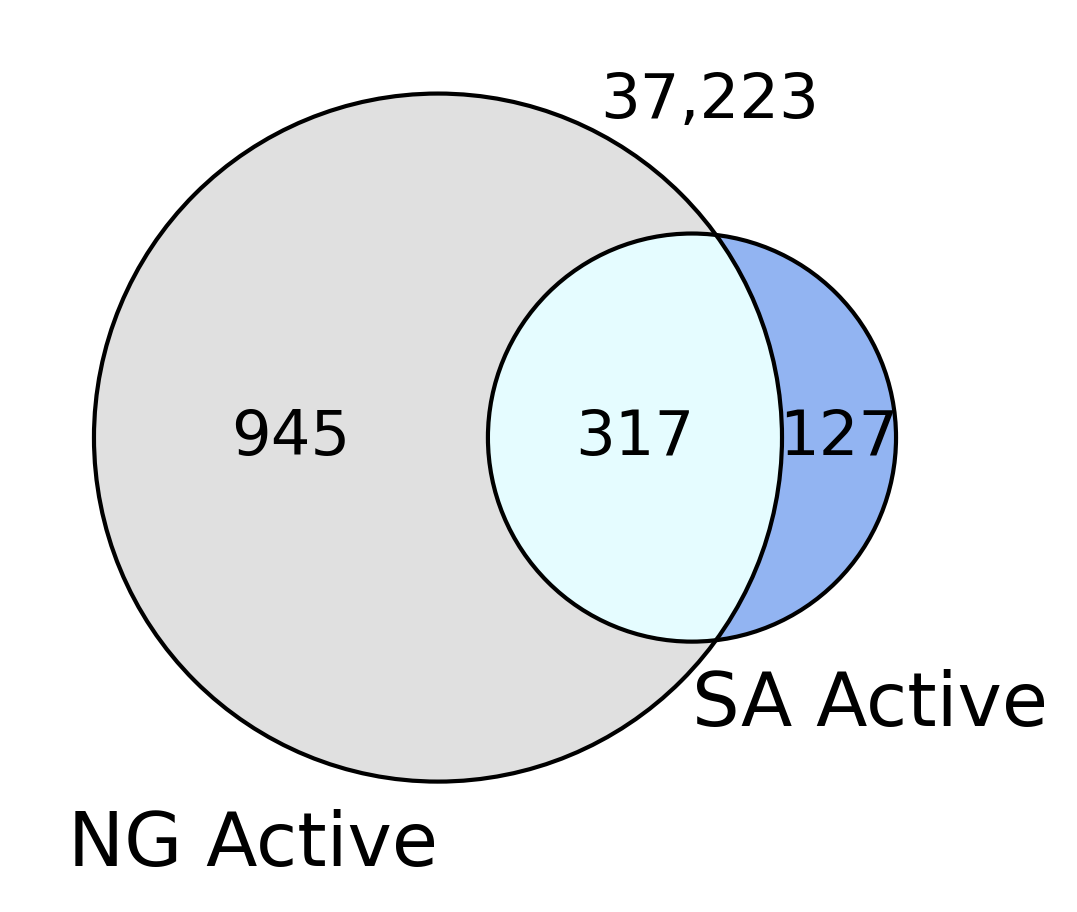

In [3]:
for i, smalldf in merge.groupby('NG_Activity'):
    for j, smallerdf in smalldf.groupby('SA_Activity'):
        print(i, j, len(smallerdf))

# depict venn diagram
subsets = (945, 127, 317)
fontsize = 15.0
plt.rcParams['font.size'] = fontsize

fig, ax = plt.subplots(figsize = (4,4), dpi = 300)
venn2(subsets = subsets, set_labels = ('NG Active', 'SA Active'), 
      set_colors=('lightgrey','cornflowerblue'),alpha=0.7, ax=ax)
venn2_circles(subsets = subsets, linewidth=1, ax=ax)
ax.text(0.15, 0.5, '37,223', fontsize=fontsize);
plt.savefig('../figure_panels/venn_diagram_sa_ng.svg')
plt.savefig('../figure_panels/venn_diagram_sa_ng.png')
plt.show()

# Part 3: Evaluate external validation sets

For this comparison, we're going to run models trained only on the 37K and (2.3K or PK, for SA and NG respectively) datasets. We will use the first validation sets generated for each project to show that each model generalizes. Then, we will use models trained on ALL available data (37K, 2.3K/PK, and validation) for the fragment analysis.

In [4]:
# SA validation dataset
out_path = '../out/controls/'
savaldf = pd.read_excel('../data/training_data/SA/Supplementary Dataset 2.xlsx', sheet_name = 'All tested compounds')
print(len(savaldf))
print(sum(savaldf['ACTIVITY']))
savaldf['class'] = [1.0 if x else 0.0 for x in list(savaldf['ACTIVITY'])]
savaldf = savaldf[['SMILES', 'class']]
savaldf.columns = ['smiles', 'class']
savaldf.to_csv(out_path + 'base_model_validation_sa_clean_val.csv', index = False)
savaldf

327
38


,smiles,class
0,OC(=O)C1CCN(CC1)c1ccc(c(c1)F)-c1ccc(c(c1)C(=O)O)O,0.0
1,OC(=O)[C@H]1CCCN(C1)c1ccc(c(c1)F)-c1ccc(c(c1)C...,0.0
2,OC(C1=C(CSC2OC(C3CCCCC3)=NN=2)C2=C(C=CC=C2F)S1)=O,1.0
3,CC(N1C(SCC2C3=C(C=CC=C3F)SC=2C(O)=O)=NN=N1)C,0.0
4,CC(C1N(C2CC2)C(SCC2C3=C(C=CC=C3F)SC=2C(O)=O)=N...,0.0
...,...,...
322,S(=O)(=O)(N1CCCCC1)N1CCCN(CC1)S(=O)(=O)N1CCCCC1,0.0
323,N1(C2C1C1CC2CC1)S(=O)(=O)C1C=CC(=CC=1)C,0.0
324,S(=O)(=O)(N1CCCCC1)N1CCN(CC1)S(=O)(=O)N1CCCC1,0.0
325,S(=O)(=O)(N1CCOCC1)N1CCN(CC1)S(=O)(=O)N1CCCC1,0.0


`chemprop_predict --test_path ../out/controls/base_model_validation_sa_clean_val.csv --checkpoint_dir ../models/SA/base_training_library --preds_path ../out/controls/base_model_validation_sa_predictions_.csv --features_generator rdkit_2d_normalized --no_features_scaling --smiles_column smiles`


In [5]:
# NG validation set
ngvaldf = pd.read_excel('../data/training_data/NG/2022-10-21 Broad800K validation with MP order 1 data summary Jackie.xlsx', header = 1)
print(len(ngvaldf))
print(sum(ngvaldf['NG_hit']))
ngvaldf['class'] = [float(x) for x in list(ngvaldf['NG_hit'])]
ngvaldf = ngvaldf[['SMILES', 'class']]
ngvaldf.columns = ['smiles', 'class']
ngvaldf.to_csv(out_path + 'base_model_validation_ng_clean_val.csv', index = False)
ngvaldf

143
70


,smiles,class
0,OC(=O)C[C@@H](S[Au])C(=O)O,1.0
1,CC(=CCN([C@@H](COC(=O)NCCCCCC(=O)NO)c1ccccc1)C...,0.0
2,CN(C)[C@H]1[C@@H]2C[C@@H]3[C@H](O)c4c(ccc(c4C(...,1.0
3,CO[C@H]1/C=C\O[C@@]2(C)Oc3c(c(c4c(c3C2=O)C(=O)...,1.0
4,C[C@H]1COc2c(c(cc3c2N1C=C(C(=O)O)C3=O)F)F,1.0
...,...,...
138,NC1=NC(=CC(NC2CC2)=N1)C1=C(F)C=C(O)C(Cl)=C1,0.0
139,[O-][N+](=O)c1ccc(\C=C\N2CCOC2=O)o1,1.0
140,CSc1ncc(Cl)c(n1)C(=O)Nc1ncc(s1)[N+]([O-])=O,1.0
141,COC(=O)C1=CC=C(NC(=O)C2=CC=C(O2)[N+]([O-])=O)C=C1,0.0


`python ../models/chemprop-master/scripts/save_features.py --data_path ../out/controls/base_model_validation_ng_clean_val.csv --features_generator rdkit_2d_normalized --save_path ../out/controls/base_model_validation_ng_clean_val --smiles_column smiles`

`chemprop_predict --test_path ../out/controls/base_model_validation_ng_clean_val.csv --checkpoint_dir ../models/NG/FINALbayHO04052022/ --preds_path ../out/controls/base_model_validation_ng_predictions.csv --features_path ../out/controls/base_model_validation_ng_clean_val.npz --no_features_scaling --smiles_column smiles`


In [6]:
plt.rcParams['font.size'] = 10

precision recall: 0.4749927414577624


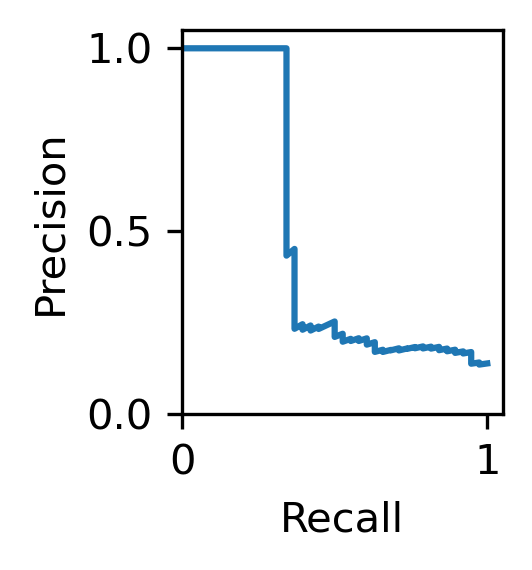

recall: 
0.34210526315789475
precision: 
0.48148148148148145


In [7]:
savaldf = pd.read_csv(out_path + 'base_model_validation_sa_predictions.csv')
evaluate_model(savaldf, cutoff_for_positive = 0.5)

precision recall: 0.6244644145834173


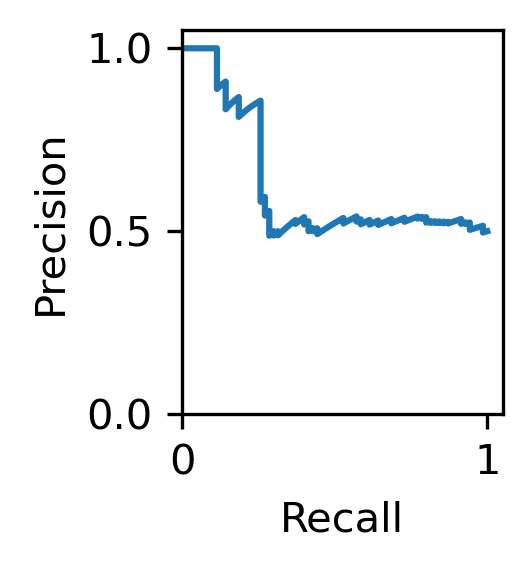

recall: 
1.0
precision: 
0.48951048951048953


In [8]:
ngvaldf = pd.read_csv(out_path + 'base_model_validation_ng_predictions.csv')
evaluate_model(ngvaldf, cutoff_for_positive = 0.2, predicted_col='hit')